# 1: Imports & Setup

In [ ]:
#  Imports & Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120


# 2: Load Model and Predict on test set

In [ ]:
# Load Model and Data
model = joblib.load("outputs/models/best_model.pkl")
X_test = pd.read_csv("outputs/data_splits/X_test.csv")
y_test = pd.read_csv("outputs/data_splits/y_test.csv")

#  Make Predictions
y_pred = model.predict(X_test)

# Get predicted probabilities
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
else:
    y_proba = np.full(len(y_pred), 0.5)
    print("Warning: Model does not support `predict_proba`. Using dummy probabilities.")

# 3: Evaluate the Model

In [ ]:
#  Evaluation Metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
}
pd.DataFrame([metrics]).to_csv("figures/evaluation_metrics.csv", index=False)
print("📈 Evaluation Metrics:")
for k, v in metrics.items():
    print(f" - {k}: {v:.4f}")

📈 Evaluation Metrics:
 - Accuracy: 0.9784
 - Precision: 0.7343
 - Recall: 0.5614
 - F1 Score: 0.6363
 - ROC AUC: 0.9249


# 4: Confusion Matrix Plot

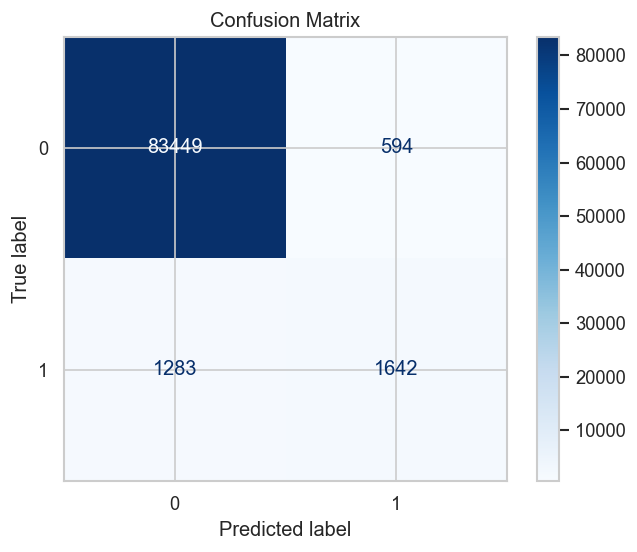

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.savefig("figures/confusion_matrix.png", bbox_inches="tight")
plt.show()

# 5: ROC Curve Plot

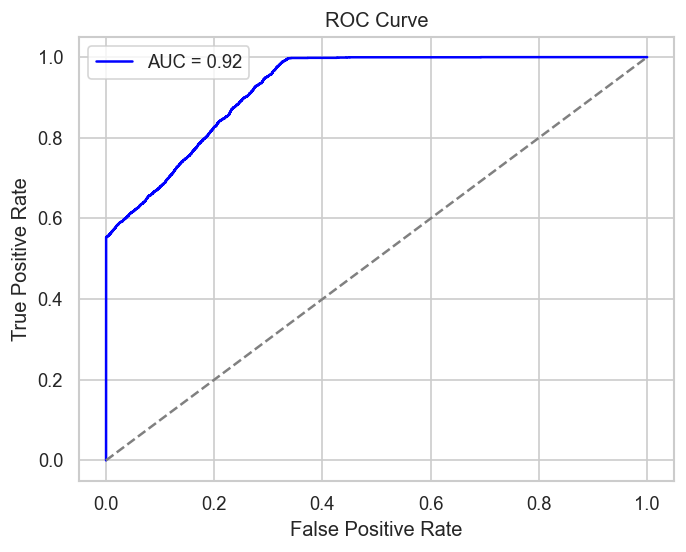

In [ ]:
#  ROC Curve
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {metrics['ROC AUC']:.2f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/roc_curve.png", bbox_inches="tight")
    plt.show()

# 6: Precision-Recall Curve

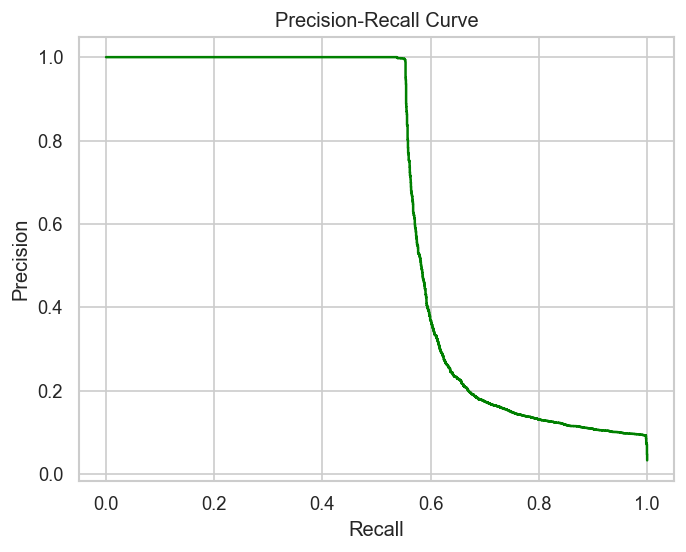

In [ ]:
#  Precision-Recall Curve
if y_proba is not None:
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.savefig("figures/pr_curve.png", bbox_inches="tight")
    plt.show()

# 7: Classification Report Heatmap

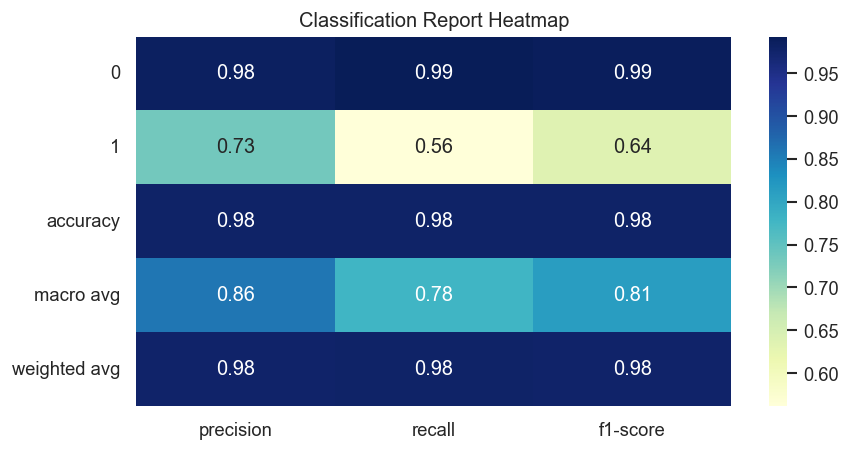

In [ ]:
#  Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1, :].T  # drop accuracy row

plt.figure(figsize=(8, 4))
sns.heatmap(df_report, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.savefig("figures/classification_report_heatmap.png", bbox_inches="tight")
plt.show()

# 8: Feature Importance

C:\Users\hp\AppData\Local\Temp\ipykernel_14480\3465736545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), palette="Blues_d")


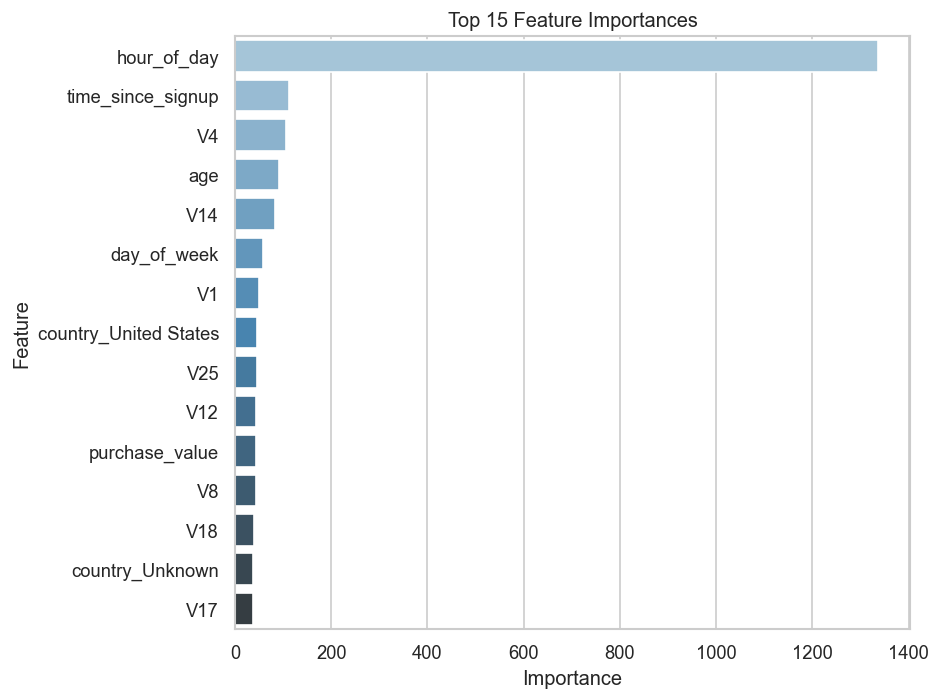

In [ ]:
#  Feature Importances
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    fi_df = pd.DataFrame({"Feature": X_test.columns, "Importance": importances})
    fi_df = fi_df.sort_values("Importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), palette="Blues_d")
    plt.title("Top 15 Feature Importances")
    plt.tight_layout()
    plt.savefig("figures/feature_importance.png", bbox_inches="tight")
    plt.show()
else:
    print("Model does not expose `feature_importances_`.")


# 9: Calibration Curve

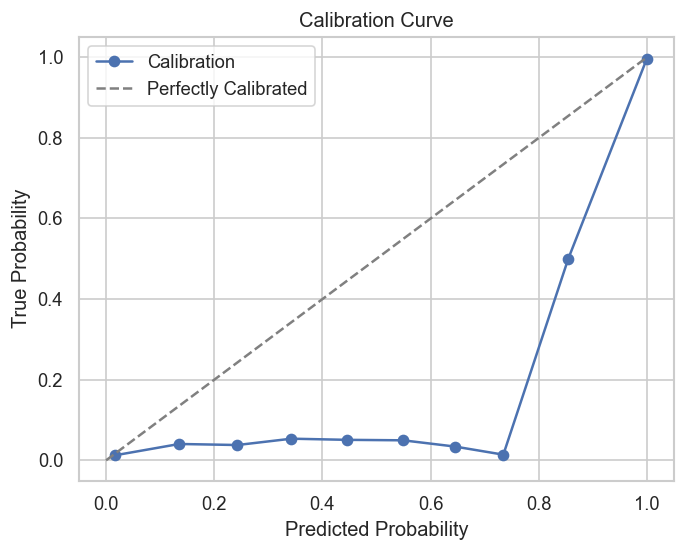

In [ ]:
#   Calibration Curve
try:
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.title("Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/calibration_curve.png", bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f" Could not plot calibration curve: {e}")